# Libs

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader

D:\development\Anaconda\envs\napari_cp2\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Data

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                # move to device
                                transforms.Lambda(lambda x: x.to(device))
                                ])
# long type for labels
target_transform = transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.long).to(device))

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True,
                          transform=transform, target_transform=target_transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False,
                         transform=transform, target_transform=target_transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


In [5]:
for el in trainset:
    x, y = el
    print(x.shape, y)
    break
for el in trainloader:
    x, y = el
    print(x.shape, y.shape)
    break

torch.Size([1, 28, 28]) tensor(5)
torch.Size([64, 1, 28, 28]) torch.Size([64])


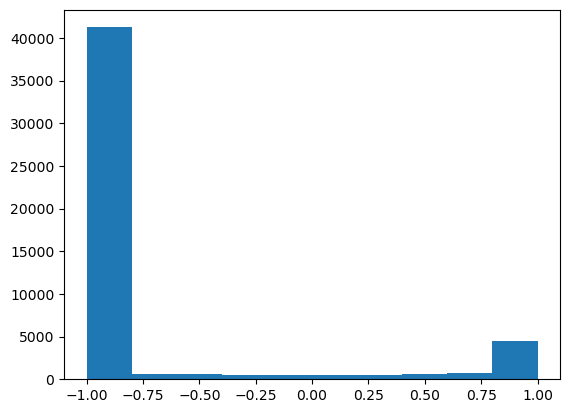

In [6]:
plt.hist(x.cpu().numpy().flatten());

# Simple CNN

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2)
        self.fc1 = nn.Linear(64*5*5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 26x26
        # print(x.shape)
        x = F.relu(self.conv2(x))  # 12x12
        # print(x.shape)
        x = F.relu(self.conv3(x))  # 5x5
        # print(x.shape)
        x = x.view(-1, 64*5*5)  # flatten 32x7x7 -> 32*7*7
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        logits = self.fc2(x)  # no activation, we will use cross-entropy loss with logits
        # print(logits.shape)
        
        probs = F.softmax(logits, dim=1)

        # Prediction: argmax for classification
        pred = torch.argmax(probs, dim=1)

        return logits, probs, pred

model = Model().to(device)

In [23]:
res = model(x)
[r.shape for r in res]

[torch.Size([64, 10]), torch.Size([64, 10]), torch.Size([64])]

In [41]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def get_npars(model):
  return np.sum([np.prod(list(p.shape)) for p in model.parameters()])

In [20]:
get_npars(model)

74858

In [31]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, _, _ = model(images)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

In [38]:
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    n_correct = 0
    n_total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()  # reset gradients
        output, _, pred = model(images)
        loss = criterion(output, labels)
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        running_loss += loss.item()
        
        correct = torch.sum(pred == labels)
        n_correct += correct.item()
        n_total += len(labels)
    acc = n_correct / n_total
        
    return running_loss / len(trainloader), acc

Defining a testing function:

In [39]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    n_correct = 0
    n_total = 0
    with torch.no_grad():
        for images, labels in testloader:
            output, prob, pred = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
            correct = torch.sum(pred == labels)
            n_correct += correct.item()
            n_total += len(labels)
    acc = n_correct / n_total
    
    return running_loss / len(testloader), acc

In [40]:
testloader.batch_size

64

Training the model

In [42]:
num_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    test_loss, test_acc = test(model, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/10, Train Loss: 0.2213, Test Loss: 0.0712, Train Acc: 0.9305, Test Acc: 0.9785
Epoch 2/10, Train Loss: 0.0711, Test Loss: 0.0527, Train Acc: 0.9787, Test Acc: 0.9837
Epoch 3/10, Train Loss: 0.0496, Test Loss: 0.0492, Train Acc: 0.9852, Test Acc: 0.9841
Epoch 4/10, Train Loss: 0.0365, Test Loss: 0.0418, Train Acc: 0.9889, Test Acc: 0.9862
Epoch 5/10, Train Loss: 0.0300, Test Loss: 0.0432, Train Acc: 0.9905, Test Acc: 0.9854
Epoch 6/10, Train Loss: 0.0229, Test Loss: 0.0461, Train Acc: 0.9927, Test Acc: 0.9864
Epoch 7/10, Train Loss: 0.0208, Test Loss: 0.0460, Train Acc: 0.9930, Test Acc: 0.9873
Epoch 8/10, Train Loss: 0.0163, Test Loss: 0.0404, Train Acc: 0.9947, Test Acc: 0.9882
Epoch 9/10, Train Loss: 0.0139, Test Loss: 0.0498, Train Acc: 0.9952, Test Acc: 0.9864
Epoch 10/10, Train Loss: 0.0116, Test Loss: 0.0492, Train Acc: 0.9961, Test Acc: 0.9875


Visualize the loss curves

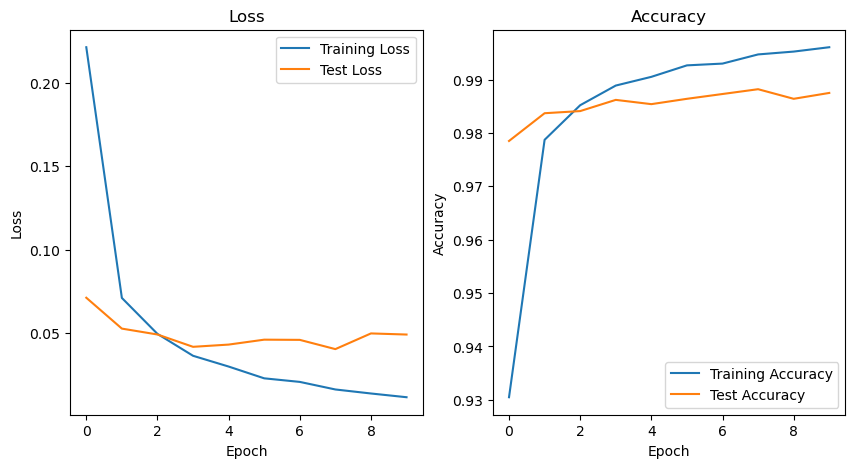

In [46]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) 
ax[0].plot(range(num_epochs), train_losses, label='Training Loss')
ax[0].plot(range(num_epochs), test_losses, label='Test Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss', title='Loss')
ax[0].legend(loc='upper right')

ax[1].plot(range(num_epochs), train_accs, label='Training Accuracy')
ax[1].plot(range(num_epochs), test_accs, label='Test Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy')
ax[1].legend(loc='lower right')
plt.show()
plt.close()

In [48]:

# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9875


# Simple CNN, with global AP

In [49]:
class ModelGP(nn.Module):
    def __init__(self):
        super(ModelGP, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2)
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 26x26
        # print(x.shape)
        x = F.relu(self.conv2(x))  # 12x12
        # print(x.shape)
        x = F.relu(self.conv3(x))  # 5x5
        # print(x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # print(x.shape)
        x = x.view(-1, 64)  # flatten 32x7x7 -> 32*7*7
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        logits = self.fc2(x)  # no activation, we will use cross-entropy loss with logits
        # print(logits.shape)
        
        probs = F.softmax(logits, dim=1)

        # Prediction: argmax for classification
        pred = torch.argmax(probs, dim=1)

        return logits, probs, pred

model_gp = ModelGP().to(device)

In [50]:
get_npars(model_gp)

25706

In [51]:
# Optimizer (e.g., Adam)
optimizer_gp = optim.Adam(model_gp.parameters(), lr=0.001)

In [52]:
num_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_gp, trainloader, criterion, optimizer_gp)
    test_loss, test_acc = test(model_gp, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/10, Train Loss: 1.2618, Test Loss: 0.6313, Train Acc: 0.5592, Test Acc: 0.8018
Epoch 2/10, Train Loss: 0.4976, Test Loss: 0.3867, Train Acc: 0.8442, Test Acc: 0.8761
Epoch 3/10, Train Loss: 0.3412, Test Loss: 0.2921, Train Acc: 0.8972, Test Acc: 0.9090
Epoch 4/10, Train Loss: 0.2725, Test Loss: 0.2543, Train Acc: 0.9185, Test Acc: 0.9219
Epoch 5/10, Train Loss: 0.2397, Test Loss: 0.2090, Train Acc: 0.9275, Test Acc: 0.9403
Epoch 6/10, Train Loss: 0.2111, Test Loss: 0.2214, Train Acc: 0.9368, Test Acc: 0.9306
Epoch 7/10, Train Loss: 0.1890, Test Loss: 0.1706, Train Acc: 0.9428, Test Acc: 0.9510
Epoch 8/10, Train Loss: 0.1705, Test Loss: 0.1466, Train Acc: 0.9486, Test Acc: 0.9553
Epoch 9/10, Train Loss: 0.1566, Test Loss: 0.1364, Train Acc: 0.9531, Test Acc: 0.9608
Epoch 10/10, Train Loss: 0.1415, Test Loss: 0.1307, Train Acc: 0.9577, Test Acc: 0.9610


Visualize the loss curves

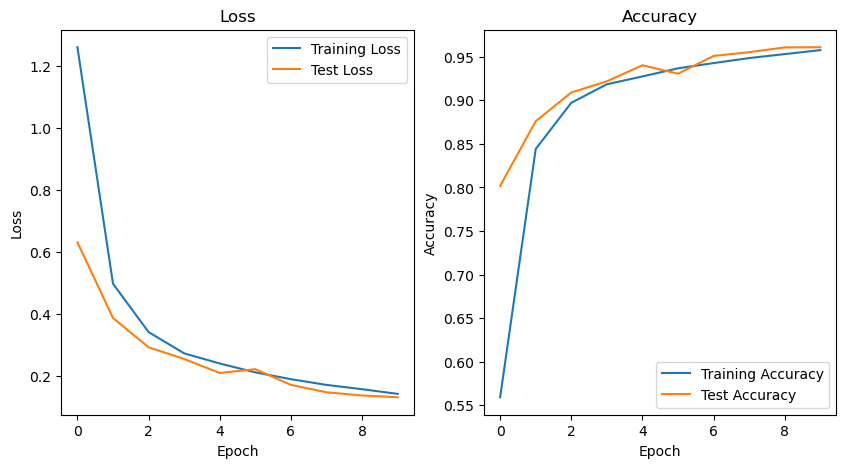

In [53]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(range(num_epochs), train_losses, label='Training Loss')
ax[0].plot(range(num_epochs), test_losses, label='Test Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss', title='Loss')
ax[0].legend(loc='upper right')

ax[1].plot(range(num_epochs), train_accs, label='Training Accuracy')
ax[1].plot(range(num_epochs), test_accs, label='Test Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy')
ax[1].legend(loc='lower right')
plt.show()
plt.close()

In [54]:
# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model_gp, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.961


In [ ]:
# ToDo: commit run longer or higher lr - not yet converged, but on a good track